# Project 3: 
# Bitcoin  - Ethereum Classifier

## Table of Contents:

1. [Background](#1.-Background)  
1. [Problem Statement](#2.-Problem-Statement)  
1. [Executive Summary](#3.-Executive-Summary)  
1. [Data Cleaning](#4.-Data-Import-and-Cleaning)  
1. [Models](#5.-Models)  
    1. [Preprocessing](#a.-Preprocessing)
    1. [Different Combinations of Vectorizers and Classifiers](#b.-Different-Combinations-of-Vectorizers-and-Classifiers)
    1. [Fine tuning and selecting final model](#c.-Fine-tuning-and-selecting-final-model)
    1. [Chosen Model: CountVectorizer with MultinomialNB](#d.-Chosen-Model:-CountVectorizer-with-MultinomialNB)
1. [Final Model](#6.-Final-Model)
1. [Conclusion and Recommendations](#6.-Conclusion-and-Recommendations)  
1. [References and Data Sources](#7.-References-and-Data-Sources) 

## 1. Background

We have been engaged by a local trading exchange who is looking to issue a new cryptocurrency contract to tap on the current hot crypto craze. They are currently deciding between a Bitcoin future contract or a Ethereum future contract. They are interested to monitor the posts on their user discussion forum on cryptos and divide these posts into Bitcoin / Ethereum posts. They believe this can help to identify which cryptocurrency is generating greater interest and thus the contract issued will generate the better interest and liquidity fast.

## 2. Problem Statement

We are tasked with building a model to identify and classify the posts into Bitcoin or Ethereum posts. We decided to train our model using posts on Reddit on the subtopics Bitcoin and Ethereum.

## 3. Executive Summary

To achieve our goal of identifing posts on our stalkholder forum, we have to create a NLP classification model. To train our model, we decided to use posts on Reddit on the subtopics of Bitcoin and Ethereum. This is because the posts would be similar to those in our forum and that Reddit have readily available a much bigger amount of data and these are already classified. The metric that we will be most concerned about will be Accuracy.

Our strategy on building this NLP classification model is to try various combinations of stemming, lemmitzing, Vectorisations and Classifiers. We find that our results weren't much different between stemming and lemmitizing so we chose stemming to cut down the number of features and increase independence between features which is the assumption for Naive Bayes (and which is not true most of the time in NLP but used as it simplify the calculations). We tried CountVectorizer, TfidfVectorizer, Hashing Vectorizer. Hashing Vectorizer doesn't provide much benefit as our dataset is small and it is hard to analyse the important features. CountVectorizer and TfidfVectorizer works better with different classifiers. For the classifiers, we tried Logistic Regression, Multinomial Naive Bayes, K Nearest Classifier and Random Forest Classifier. K Nearest Classifier doesn't perform well. Logistic Regression and Random Forest accuracy are reasonable but Multinominal Naive Bayes is the best and it is the model whereby we can control the variance down without sacrificing the accuracy of the model much.

Our best model is a Multinominal Naive Bayes Model with Count Vectoriser. This model achieve an accuracy of 84.5% on unseen data and 88% on seen data. We feel that this model is the best because firstly it is the model with the highest accuracy. It is not overfitting and have reasonable variance. Our best params are the following: 'cvec__max_df': 0.1, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.5.
When we look the top words that differientate between Bitcoins and Ethereum. We can resonate with them (more of these in the final model section). The posts that were misclassified are mostly spam posts. Also it is the fastest to tune and compute over GridSearchCV when we have to refit our model with new data in the future.

In conclusion, we believe our model is adequte to solve the problem statement.

Going forward, as we are only training our model with 1309 data points with 4541 features, we have to cap the number of featur
es to prevent overfitting. When we have more data, we can improve our accuracy by refitting it to our model and relaxing some of the hyperparameters used to control the overfitting.

## 4. Data Import and Cleaning

Data have been scapped from Reddit by 'Bitcoin - Reddit Scrapper.ipynb' and 'Ethereum - Reddit Scapper.ipynb' in the code folder and saved as csv files in the datasets folder.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import regex as re
import string

from IPython.display import display

In [2]:
#importing data

btc_data = pd.read_csv('../datasets/bitcoins.csv')
eth_data = pd.read_csv('../datasets/ethereum.csv')

In [3]:
# combining title and selftext and concat both dataframe into 1
btc_data['text'] = btc_data['title'] + (' ' + btc_data['selftext']).fillna('')
eth_data['text'] = eth_data['title'] + (' ' + eth_data['selftext']).fillna('')
data = pd.concat([btc_data[['subreddit','text']], eth_data[['subreddit','text']]])

In [4]:
# replacing Bitcoin with 0 and ethereum with 1
data['subreddit'] = data['subreddit'].map({'Bitcoin' : 0, 'ethereum' : 1})

In [5]:
data.head()

,subreddit,text
0,0,"Daily Discussion, June 16, 2021 Please utilize..."
1,0,Tim Draper is still bullish that bitcoin will ...
2,0,MicroStrategy keeps backing up the truck on bi...
3,0,While you still slave away for a half day off
4,0,Tanzania's president is now calling for Bitcoi...


In [6]:
data.shape

(1309, 2)

## 5. Models

The metric that we are most concern about will be Accuracy. We are not particularly intolerable towards false negative or flase postive. The cost of having false positve and false negative are the same to us so we choose Accuracy over Specificity or Sensitivity. This will be what we used to measure our models with and decide on which is the best model.

### a. Preprocessing

Before we fit the data into the model. We have to preprocess our text. We choose to tokenize our text by words and also change the words back to their root form by either stemming or lemmatizating and removing stop words using the 'english' in nltk so they will remove all the common words which are not useful in differentiating between the 2 classes and reduce the number of features.

In [7]:
def preparetext(document, shorten = 'stemmer'):
          
    '''
    DocString
    ----------
    To clean up text and return a list of texts.
    1. Tokenize the words
    2. Convert all text to lowercase
    3. Stem the words
    4. Remove stopwords

       
    Parameters:
    ----------
    document:        Series which contains the text data
    shorten:         Methods to shorten the words in the text. 'lemmatizer' or 'stemmer'
   
    '''
    meaningful_words = []
    for text in document:
        text = text.lower()
        text = re.sub('[^\w\s]|http[s*]:\/\/\w+.\S+.',' ',text)
        tokens = text.split()
        
        if shorten == 'lemmatizer':
            lemmatizer = WordNetLemmatizer()
            shorten_tokens = [lemmatizer.lemmatize(i) for i in tokens]
        elif shorten == 'stemmer':
            p_stemmer = PorterStemmer()
            shorten_tokens = [p_stemmer.stem(i) for i in tokens]
        else: 
            print('Error')
            break
        stop = set(stopwords.words('english') +  
                   ['bitcoin', 'bitcoins', 'btc', 'eth', 'ethereum']+
                   ['reddit'])
        meaningful = [word for word in shorten_tokens if word not in stop]
        meaningful = " ".join(meaningful)
        meaningful_words.append(meaningful)
    return meaningful_words

In [8]:
X = data['text']
y = data['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= 0.25,
                                                    random_state = 42,
                                                    stratify = y)

In [9]:
X_train_features = preparetext(X_train)
X_test_features = preparetext(X_test)

In [10]:
X_train_features

['opinion el salvador play danger game bet big',
 'sienta newslett 4 weekli updat real world asset defi',
 'care freak kim jong un major politician larg follow endors bullish news period',
 'new websit fe evm languag',
 'thi video explain whi ban mine china help',
 'meetup',
 'address obviou problem address problem make better ani viabl solut current transact fee 13 41 use daili transact currenc fee thi high sourc averag transact time 5 4 hour lightn network seem like convolut solut thi sourc energi usag per transact averag energi consumpt one singl transact 2021 equal sever hundr thousand visa card transact sourc anonym effort requir protect privaci transact store publicli perman network mean anyon see balanc transact ani address sourc store valu becaus problem deem currenc seem 2008 technolog tri best hang 2021 almost like use iphon 3g 2008 today',
 'ga fee plung six month low whi',
 'build rigor enabl homebuild access fund web3 open beta',
 'geth snap sync vs fast sync anyon tell ad

In [11]:
X_train_features_lemmatizer = preparetext(X_train, shorten = 'lemmatizer')
X_test_features_lemmatizer = preparetext(X_test, shorten = 'lemmatizer')

In [12]:
X_train_features_lemmatizer

['opinion el salvador playing dangerous game betting big',
 'sienta newsletter 4 weekly update real world asset defi',
 'care freaking kim jong un major politician large following endorses bullish news period',
 'new website fe evm language',
 'video explains banning mining china help',
 'meetup',
 'addressing obvious problem address problem make better viable solution current transaction fee 13 41 used daily transaction currency fee high source average transaction time 5 4 hour lightning network seems like convoluted solution source energy usage per transaction average energy consumption one single transaction 2021 equal several hundred thousand visa card transaction source anonymous effort required protect privacy transaction stored publicly permanently network mean anyone see balance transaction address source store value problem deemed currency seems 2008 technology trying best hang 2021 almost like using iphone 3g 2008 today',
 'gas fee plunged six month low',
 'build rigor enable

In [13]:
cvec = CountVectorizer()
cvec.fit_transform(X_train_features)

<981x4541 sparse matrix of type '<class 'numpy.int64'>'
	with 22834 stored elements in Compressed Sparse Row format>

In [14]:
cvec.fit_transform(X_train_features_lemmatizer)

<981x5676 sparse matrix of type '<class 'numpy.int64'>'
	with 22697 stored elements in Compressed Sparse Row format>

We have tried lemmatizing and stemming the documents and it didn't affect our results significantly. This show that our models are not too concerned with the different forms of a word. We shall proceed with stemming for the rest of this report as it decreases our features to 4541 compared to lemmatizer and thus save computational capacity. Also as our data points are only 981 and features much higher, we have to be very careful of overfitting and thus choose stemming to cut down the number of features more.

### b. Different Combinations of Vectorizers and Classifiers

Our strategy here is to first try as many different combinations of Vectorizers and Classifiers as possible. We like to find out which combination of Vectorizer and Classifier best fit our data prediction here without spending too much time on tuning the hyperparameters. We will then choose a few of these best combinations to further tune the hyperparameters and seek to achieve a better results. The metric we will be mainly focusing on is accuracy score here. We will also look at the confusion matrix to have a gauge of the performance of the model in other metrics.

In [15]:
#baseline score
y_test.value_counts(normalize=True)

0    0.597561
1    0.402439
Name: subreddit, dtype: float64

Baseline score is 0.598. This means that if we do not predict which class the text belongs to by using a classifier model but instead guess all text to be from a single class, we could also achieve a score of 0.598.

#### Model 1: CountVectorizer with LogisticRegression

In [16]:
def pipeline_gscv(X_train, y_train, X_test, y_test, pipe, params, display_coeff = True):
        
    '''
    DocString
    ----------
    Function to perform the repetitive code of running the GridSearchCV on the pipeline model and display metrics for evaluation.
       
    Parameters:
    ----------
    X_train:         Training set features
    y_train:         Training set targets
    X_test:          Testing set features
    y_test:          Testing set targets
    pipe:            Pipeline model
    params:          Pipeline parameters
   
    '''
    gs = GridSearchCV(pipe,
                      param_grid = params,
                      cv = 5,
                      verbose = 1)
    
    gs.fit(X_train,y_train)
    
    print(f'Best Grid Search Score: {gs.best_score_}')
    print(f'Best Params: {gs.best_params_}')
    
    model = gs.best_estimator_
    print(f'Best Model Train Score: {model.score(X_train, y_train)}')
    print(f'Best Model Test Score: {model.score(X_test,y_test)}')
    
    if display_coeff:
        coefficients = pd.DataFrame(model[-1].coef_.T, index = model[0].get_feature_names(), columns = ['coef'])
        display(coefficients.sort_values('coef',ascending = True).head(10))
        display(coefficients.sort_values('coef', ascending = False).head(10))
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    
    return model

In [17]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

params1 = {'cvec__max_features': [1000,2000,3000,4000],
           'lr__C': [0.1,1,10]}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Grid Search Score: 0.8042525639697503
Best Params: {'cvec__max_features': 3000, 'lr__C': 1}
Best Model Train Score: 0.9877675840978594
Best Model Test Score: 0.8201219512195121


,coef
taproot,-1.242632
lightn,-1.213896
fud,-1.191615
el,-1.044367
keep,-1.041594
look,-0.947196
onli,-0.869792
salvador,-0.834895
energi,-0.834095
microstrategi,-0.821999


,coef
defi,1.662838
stake,1.611275
nft,1.491697
gwei,1.444076
vitalik,1.314451
ga,1.173046
token,1.157307
etherium,1.148658
ether,1.076469
build,0.957563


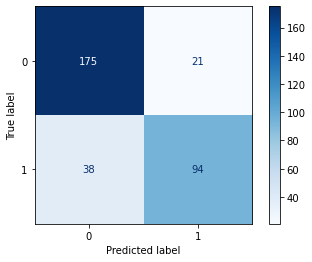

In [18]:
model1 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe1, params1)

This model is just a simple LogisticRegression with CountVectorizer for our first model. We achieve a test score of 0.820 accuracy which is 22% more accurate than the baseline. 

The top words for both classes looks sensible in differienting between the 2. The top 5 words which help to identify the 'Bitcoin' class are taproot, lightn, fud, el, keep' Taproot is a Bitcoin upgrade. Fud is 'Fear, uncertainty and doubt' which will appear more in bitcoin than ethereum due to bitcoin higher price. Lightn is the Lightning Network which is added to the Bitcoin's network. El Salvdaor wanted to implement bitcoin as their legal tender. The top 5 words which identify 'Ethereum' class from 'Bitcoin' are 'defi, stake, nft, gwei, vitalik'. Defi is the decentralised finance movement where most of the DeFi projects built on Ethereum. Gwei is a denomination of Ethererum. Vitalik is the founder of Ethereum. Staking for Ethereum is what mining is to Bitcoin as Ethereum is using POS while Bitcoin is using POW. NFTs are the smart contracts in Ethereum which differentiate itself from Bitcoins and make it a 2nd generation crypto.

Even though the train score and test score differ significantly showing overfitting as we previously expected, the best estimator over GridSearchCV only returns C = 1 not 0.1.

#### Model 2: CountVectorizer with MultinomialNB

In [19]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params2 = {'cvec__max_features': [1000,2000,3000,4000],
           'nb__alpha': [0.9,0.1]}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Grid Search Score: 0.8216098622189992
Best Params: {'cvec__max_features': 3000, 'nb__alpha': 0.9}
Best Model Train Score: 0.9367991845056065
Best Model Test Score: 0.8384146341463414


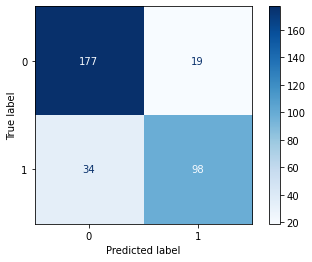

In [20]:
model2 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe2, params2, display_coeff=False)

In [21]:
coefficients = pd.DataFrame(model2[-1].feature_log_prob_.T, index = model2[0].get_feature_names(), columns = ['btc','eth'])
coefficients['prob_diff'] = np.exp(coefficients['eth']) - np.exp(coefficients['btc'])
display(coefficients.sort_values('prob_diff',ascending = True).head(10))
display(coefficients.sort_values('prob_diff', ascending = False).head(10))

,btc,eth,prob_diff
el,-5.367705,-8.209832,-0.004393
salvador,-5.400531,-8.209832,-0.004242
buy,-5.305119,-6.869447,-0.003927
bank,-5.423029,-7.278273,-0.003723
currenc,-5.518453,-7.795856,-0.003601
mine,-5.457754,-6.686007,-0.003015
price,-5.493730,-6.484321,-0.002585
money,-5.637958,-6.804489,-0.002451
energi,-5.989207,-9.676169,-0.002443
countri,-5.789995,-7.384757,-0.002437


,btc,eth,prob_diff
ga,-7.967707,-5.202627,0.005156
token,-10.004589,-5.478132,0.004132
eip,-10.004589,-5.478132,0.004132
stake,-8.309993,-5.478132,0.003931
contract,-7.422690,-5.494967,0.003510
state,-7.422690,-5.494967,0.003510
blockchain,-6.291017,-5.254654,0.003370
defi,-7.967707,-5.962597,0.002227
smart,-7.606694,-5.909814,0.002216
nft,-8.834518,-6.108202,0.002079


We used a Multinominal Naive Bayes here with CountVectorizer. MultinominalNB is choosen over GaussianNB and CategorialNB as our features are words. We achieve a test score of 0.838 accuracy which is 24% more accurate than the baseline. We look at the difference in the P(Document belong to Bitcoin class | a word exist in the document) against P(Document belong to Ethereum class | a word exist in the document) with the most positive the difference, the word helps to identify the Ethereum class and most negative difference helps to identify the Bitcoin class.

The top words have some similar ones with our model 1. The top 2 words which help to identify the 'Bitcoin' class are el and salvador which also appear in our LogisticRegression top features. Seem like taproot, lightning, fud and keep have dropped down the ranking to within the top 20 instead. The next top 3 words are buy, bank and currenc which are different. These terms might be top due to hot buying in the Bitcoin trading compared to Ethereum recently and tfidf have given them extra weightage compared to them compared to the CountVectorizer.

The top 5 words which identify 'Ethereum' class from 'Bitcoin' are ga, token, eip, stake, contract. Stake is also appear in our model 1 top 5 features. 'defi, nft, vitalik' have dropped down the ranks but still within the top 20. Ga, token, eip, contract are also words associated with Ethereum. Ga should be stemmed from Gas which is the fee for conducting a Ethereum transcation. Eip is Ethereum improvement Proposals. Token and Contract are common in Ethereum network as Ethereum network support blockchain of many different cryptocurrencies other than Ethereum themselves, these are referred to as tokens.

#### Model 3: CountVectorizer with KNeighborsClassifier

In [22]:
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

params3 = {'cvec__max_features': [1000,2000,3000,4000],
           'knn__n_neighbors': [3,5,8],
           'knn__p': [1,2]}

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Grid Search Score: 0.6911478296902518
Best Params: {'cvec__max_features': 4000, 'knn__n_neighbors': 5, 'knn__p': 2}
Best Model Train Score: 0.8246687054026504
Best Model Test Score: 0.7073170731707317


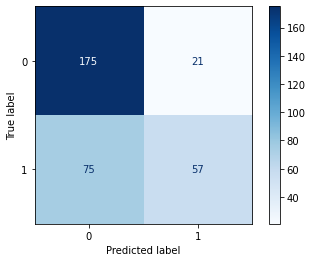

In [23]:
model3 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe3, params3, display_coeff=False)

This model does not have high accuracy. This is probably due to too many features. We shall use TfidfVectoriser later with Knn later to see if it helps improve the results.

#### Model 4: TfidfVectorizer with LogisticRegression

In [24]:
pipe4 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params4 = {'tfidf__max_features': [1000,2000,3000,4000],
           'lr__C': [0.1,1,10]}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Grid Search Score: 0.8113798819019994
Best Params: {'lr__C': 10, 'tfidf__max_features': 3000}
Best Model Train Score: 0.9928644240570846
Best Model Test Score: 0.8170731707317073


,coef
taproot,-4.281173
lightn,-4.110973
el,-3.572260
fud,-3.439127
salvador,-3.139218
energi,-3.002159
keep,-2.861264
onli,-2.726325
mine,-2.648341
hodl,-2.530914


,coef
stake,6.176236
defi,5.366172
ga,4.938660
token,4.647842
vitalik,4.512893
nft,4.490807
gwei,4.330532
etherium,3.915083
ether,3.706571
contract,3.678554


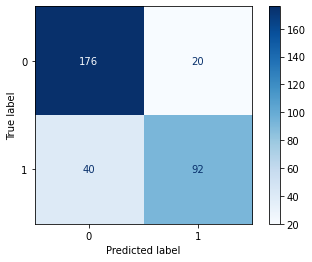

In [25]:
model4 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe4, params4)

This model doesn't have much difference compared to using CountVectorizer with Logistics Regression. The train and GridSearchCV best score are higher but test score is lower but all differences are not significant. The accuracy is still lower than using MultinominalNB. The top features are similar to our top features in model 1 and model 2 which is a consistant result.

Also this model still show overfitting but the GridSeachCV best estimator return C = 10 over C = 1 or C = 0.01 which will regularize more strongly. 

#### Model 5: TfidfVectorizer with MultinomialNB

In [26]:
pipe5 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

params5 = {'tfidf__max_features': [1000,2000,3000,4000],
           'nb__alpha': [0.9,1]}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Grid Search Score: 0.8134310577022686
Best Params: {'nb__alpha': 0.9, 'tfidf__max_features': 2000}
Best Model Train Score: 0.9051987767584098
Best Model Test Score: 0.8292682926829268


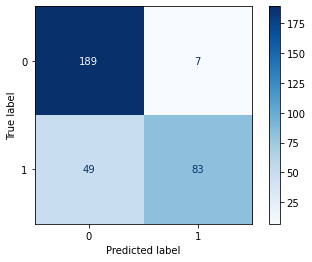

In [27]:
model5 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe5, params5, display_coeff=False)

In [28]:
coefficients = pd.DataFrame(model5[-1].feature_log_prob_.T, index = model5[0].get_feature_names(), columns = ['btc','eth'])
coefficients['prob_diff'] = np.exp(coefficients['eth']) - np.exp(coefficients['btc'])
display(coefficients.sort_values('prob_diff',ascending = True).head(10))
display(coefficients.sort_values('prob_diff', ascending = False).head(10))

,btc,eth,prob_diff
el,-5.439911,-7.542777,-0.003810
salvador,-5.479520,-7.540916,-0.003640
mine,-5.714808,-6.997164,-0.002382
bank,-5.903660,-7.360915,-0.002094
buy,-5.803601,-6.983667,-0.002090
thi,-5.223603,-5.689493,-0.002007
energi,-6.195964,-8.161554,-0.001752
taproot,-6.062855,-7.417378,-0.001727
currenc,-6.185914,-7.630344,-0.001573
lightn,-6.225195,-7.733156,-0.001541


,btc,eth,prob_diff
defi,-7.812313,-5.641077,0.003144
stake,-7.860927,-5.807499,0.002619
token,-8.372170,-5.941552,0.002397
ga,-7.597583,-5.859322,0.002352
nft,-8.036492,-6.022809,0.002099
contract,-7.677769,-5.976158,0.002076
eip,-8.372170,-6.097535,0.002017
gwei,-8.372170,-6.169828,0.001860
smart,-7.600651,-6.180047,0.001570
launch,-7.548540,-6.256352,0.001391


This model show better specificity but worse sensitivity. The false positve is lower but the false positive are higher. The accuracy score compared to CountVectorizer with Multinominal is not as accurate. A check on the different in the bayes probability shows that with Tfidf the difference is lower for example, for the top Ethereum feature, the difference in the bayes probability is only 0.003 compared to the 0.005 when using the CountVectorizer. This is true across both classes and across the top 20 features. The smaller difference make it harder to differentiate between the 2 classes and thus the slightly lower accuracy.

#### Model 6: TfidfVectorizer with KNeighborsClassfier

In [29]:
pipe6 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

params6 = {'tfidf__max_features': [1000,2000,3000,4000],
           'knn__n_neighbors': [3,5,8],
           'knn__p': [1,2]}

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Grid Search Score: 0.7951103283953176
Best Params: {'knn__n_neighbors': 8, 'knn__p': 2, 'tfidf__max_features': 4000}
Best Model Train Score: 0.8644240570846076
Best Model Test Score: 0.7957317073170732


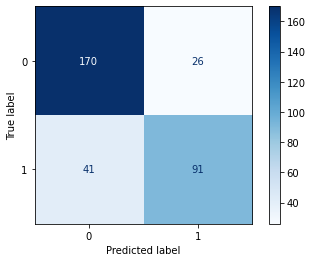

In [30]:
model6 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe6, params6, display_coeff=False)

KNeighborsClassifier with TfidfVectorizer show a much improved accuracy compared to its CountVectorizer counterpart. The test accuracy improved greatly from 0.707 to 0.796. This is as expected as the TfidfVectorizer helps give higher weightage to the neighbors which occurs more frequently only in 1 class but not both class, giving different weightage to different Neighbors. Such weightage is much more appreciated in KNeighborsClassifier than in MultinominalNB or LogisticRegression models. However it still is poorer than the accuracy of the Logistic Regression and Multinominal Naive Bayes models. Also KNeighborsClassifier demands more computation, we shall drop KNeighborClassifier.

#### Model 7: HashingVectorizer with LogisticRegression

In [31]:
pipe7 = Pipeline([
    ('hash', HashingVectorizer()),
    ('lr', LogisticRegression())
])

params7 = {'hash__n_features': [1000,2000,3000,4000],
           'lr__C': [0.1,1,10]}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Grid Search Score: 0.791023516005387
Best Params: {'hash__n_features': 4000, 'lr__C': 1}
Best Model Train Score: 0.9031600407747197
Best Model Test Score: 0.8109756097560976


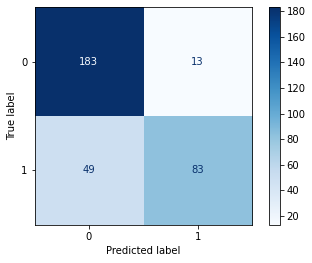

In [32]:
model7 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe7, params7, display_coeff=False)

Similar results with all other Logistic Regression models. However it is not easy to analyse important features here.

#### Model 8: HashingVectorizer with MultinomialNB

In [33]:
pipe8 = Pipeline([
    ('hash', HashingVectorizer(alternate_sign=False)),
    ('nb', MultinomialNB())
])

params8 = {'hash__n_features': [1000,2000,3000,4000],
           'nb__alpha': [0.9,1.0]}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Grid Search Score: 0.7542888221278359
Best Params: {'hash__n_features': 3000, 'nb__alpha': 0.9}
Best Model Train Score: 0.8501529051987767
Best Model Test Score: 0.7713414634146342


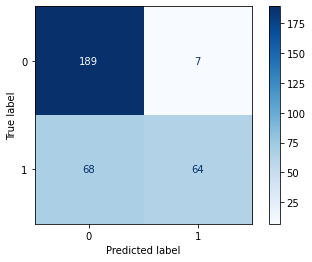

In [34]:
model8 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe8, params8, display_coeff=False)

HashingVectorizer perform much worse than the other Vectorizers with MultinominalNB. This is expected as our number of features are not high enough and it could results in distinct tokens being mapped to the same feature index. As our data set is not large, there is no significant advantages in using the hashing Vectorizer.

#### Model 9: HashingVectorizer with KNeighborsClassfier

In [35]:
pipe9 = Pipeline([
    ('hash', HashingVectorizer()),
    ('knn', KNeighborsClassifier())
])

params9 = {'hash__n_features': [1000,2000,3000,4000],
           'knn__n_neighbors': [3,5,8],
           'knn__p': [1,2]}

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Grid Search Score: 0.7553403087123175
Best Params: {'hash__n_features': 4000, 'knn__n_neighbors': 8, 'knn__p': 2}
Best Model Train Score: 0.8318042813455657
Best Model Test Score: 0.7286585365853658


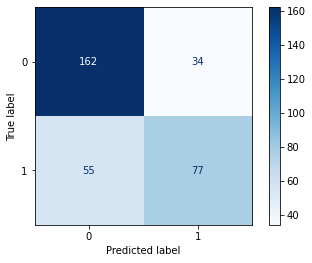

In [36]:
model9 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe9, params9, display_coeff=False)

Similar problems with model 7 and 8. We shall drop hashing Vectorizer as it provide no signicant advantages as our data size is not big and it create complications such as difficulty to identify important features and indexing collisions.

#### Model 10: CountVectorizer with RandomForestClassifier

In [37]:
pipe10 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rt', RandomForestClassifier(n_estimators = 100, n_jobs = -1))
])
    
params10 = {'cvec__max_features': [1000,2000,3000,4000],
           'rt__max_depth': [3,5,10,None],
           'rt__min_samples_leaf': [1,2,3]}

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Grid Search Score: 0.7981715528851134
Best Params: {'cvec__max_features': 3000, 'rt__max_depth': None, 'rt__min_samples_leaf': 1}
Best Model Train Score: 0.9969418960244648
Best Model Test Score: 0.8140243902439024


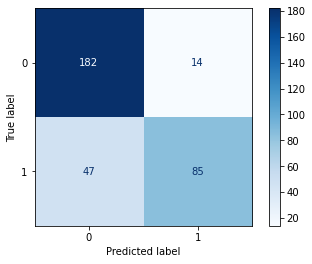

In [38]:
model10 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe10, params10, display_coeff=False)

In [39]:
coefficients = pd.DataFrame(model10[-1].feature_importances_.T, index = model10[0].get_feature_names(), columns = ['coef'])
display(coefficients.sort_values('coef', ascending = False).head(20))

,coef
defi,0.025152
nft,0.016999
token,0.015412
stake,0.014698
gwei,0.011934
contract,0.011841
el,0.010476
eip,0.008817
salvador,0.008458
ether,0.007947


The Random Forest Classifier with Count Vectorizer perform around the same as the Logistic Regression models but still not as accurate as the Multinominal Naive Bayes models. The important features are inline with all the performing models. The train score and test score differ greatly, showing overfitting.

#### Model 11: TfidfVectorizer with RandomForestClassifier

In [40]:
pipe11 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rt', RandomForestClassifier(n_estimators = 100, n_jobs = -1))
])
    
params11 = {'tfidf__max_features': [1000,2000,3000,4000],
           'rt__max_depth': [3,5,10,None],
           'rt__min_samples_leaf': [1,2,3]}

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Grid Search Score: 0.799166062364032
Best Params: {'rt__max_depth': None, 'rt__min_samples_leaf': 1, 'tfidf__max_features': 4000}
Best Model Train Score: 0.9989806320081549
Best Model Test Score: 0.7865853658536586


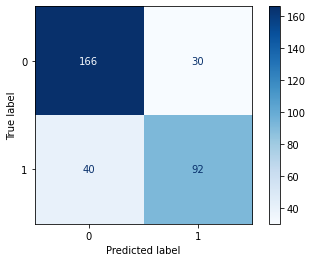

In [41]:
model11 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe11, params11, display_coeff=False)

In [42]:
coefficients = pd.DataFrame(model11[-1].feature_importances_.T, index = model11[0].get_feature_names(), columns = ['coef'])
display(coefficients.sort_values('coef', ascending = False).head(20))

,coef
defi,0.023748
nft,0.013803
token,0.013513
contract,0.012781
stake,0.012321
el,0.011249
ga,0.009916
gwei,0.009825
salvador,0.009373
eip,0.008532


Lower accuracy than its Count Vectorizer counterpart. The most important features are similar.

#### Selecting best combinations

| Train Scores       | Logistic Regression | Multinomial Naive Bayes | K Nearest Neighbors Classifier | Random Forest Classifier |
|--------------------|---------------------|-------------------------|--------------------------------|--------------------------|
| Count Vectorizer   | 0.987               | 0.936                   | 0.824                          | 0.997                    |
| Tfidf Vectorizer   | 0.993               | 0.905                   | 0.864                          | 0.997                   |
| Hashing Vectorizer | 0.903               | 0.85                    | 0.832                          | -                        |

| Test Scores        | Logistic Regression | Multinomial Naive Bayes | K Nearest Neighbors Classifier | Random Forest Classifier |
|--------------------|---------------------|-------------------------|--------------------------------|--------------------------|
| Count Vectorizer   | 0.820                | 0.838                   | 0.707                          | 0.820                     |
| Tfidf Vectorizer   | 0.817               | 0.829                   | 0.796                          | 0.808                    |
| Hashing Vectorizer | 0.811               | 0.771                   | 0.729                          | -                        |

Logistic Regression produce pretty consisent accuracy across all 3 Vectorizer. Multinominal Naive Bayes seem to work better with Count Vectorizer on default hyperparameters. K Nearest Neighbours Classifier doesn't seem to perform well. Random Forest Classifier is around the same accuracy as Logistic Regression but still not better than Multinominal Naive Bayes. HashingVectorizer doesn't give much benefit and have more disadvantages for this dataset.

We shall discard the K Nearest Neighbors Classifer and Hashing Vectorizer and concentrate on further fine tuning 1 model each of Logistics Regression, Multinominal Naive Bayes and Random Forest Classifier to try to further improve on the accuracy. We choose model 2 (Count Vectorizer with Multinominal Naive Bayes), model 4 (TfidfVectorizer with Logistic Regression) and model 10 (Count Vectorizer with Random Forest Classifer) for more exploration.

We also notice here from the train and test scores that all our models overfit. This is probably due to the number of features greatly exceeding the number of data that we have. As mentioned at the start of the project our X_train only have 981 data compared to 4541 features. Most of our models have differences between the train and the test score of 9 -15% with Random Forest Classifier with TfidfVectorizer as high as 19%.

### c. Fine tuning and selecting final model

In this section, we shall further tune the hyperparameters of our 3 selected models to try to improve the accuracy. More importantly, we will seek to reduce overfitting. At this junction, it is hard for us to gain access to more data to reduce overfitting so we will try to limit the number of feathers or using other hyperparameter so as to provide overfitting. 

#### Model 12: CountVectorizer with MultinomialNB

In [43]:
pipe12 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params12 = {'cvec__max_df': [0.1,0.2,0.3],
            'cvec__max_features': [500,800,1000],
            'cvec__min_df': [1,2,3],
            'cvec__ngram_range':[(1, 1),(1,2)],
            'nb__alpha': [0.4,0.5]
           }

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Grid Search Score: 0.8032787734383093
Best Params: {'cvec__max_df': 0.2, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.4}
Best Model Train Score: 0.8817533129459735
Best Model Test Score: 0.8445121951219512


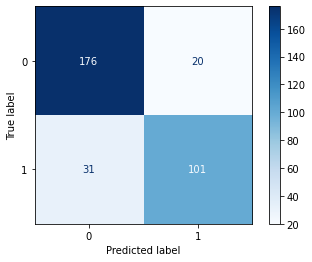

In [44]:
model12 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe12, params12, display_coeff=False)

In [45]:
coefficients = pd.DataFrame(model12[-1].feature_log_prob_.T, index = model12[0].get_feature_names(), columns = ['btc','eth'])
coefficients['prob_diff'] = np.exp(coefficients['eth']) - np.exp(coefficients['btc'])
display(coefficients.sort_values('prob_diff',ascending = True).head(20))
display(coefficients.sort_values('prob_diff', ascending = False).head(20))

,btc,eth,prob_diff
el,-5.032049,-7.952077,-0.006173
salvador,-5.065056,-7.952077,-0.005962
buy,-4.969136,-6.508624,-0.005459
bank,-5.087681,-6.935143,-0.005199
currenc,-5.183678,-7.489453,-0.005048
mine,-5.122609,-6.319382,-0.004159
price,-5.158801,-6.112462,-0.003533
energi,-5.658226,-10.092143,-0.003447
countri,-5.457187,-7.047621,-0.003396
money,-5.303983,-6.441485,-0.003378


,btc,eth,prob_diff
ga,-7.701878,-4.814029,0.007663
token,-10.474467,-5.091558,0.006120
eip,-10.474467,-5.091558,0.006120
stake,-8.076572,-5.091558,0.005838
state,-7.124563,-5.108537,0.005240
contract,-7.124563,-5.108537,0.005240
blockchain,-5.963608,-4.866396,0.005130
defi,-7.701878,-5.581284,0.003316
smart,-7.317467,-5.527795,0.003311
ani,-5.580366,-4.980155,0.003102


After limiting the max_features, although the train accurarcy decreases, the test accuracy improved. The top features are similar and relevant. We view this as a better model as model which has less variance and is a better model than model 2.

#### Model 13: TfidfVectorizer with Logistic Regression

In [46]:
pipe13 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params13 = {'tfidf__max_df': [0.2,0.3],
            'tfidf__max_features': [500,1000],
            'tfidf__min_df': [2,3],
            'tfidf__ngram_range':[(1,2)],
            'lr__C': [0.1,0.5,1]            
           }

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Grid Search Score: 0.8052833316067544
Best Params: {'lr__C': 1, 'tfidf__max_df': 0.2, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Best Model Train Score: 0.9011213047910296
Best Model Test Score: 0.823170731707317


,coef
taproot,-1.680483
fud,-1.492349
el,-1.460595
mine,-1.448176
buy,-1.323241
energi,-1.319616
bank,-1.306395
lightn,-1.289969
el salvador,-1.284571
salvador,-1.284571


,coef
defi,2.448359
stake,2.389690
token,2.065133
nft,1.981560
ga,1.761538
contract,1.545191
eip,1.495305
gwei,1.427009
vitalik,1.417597
ether,1.401356


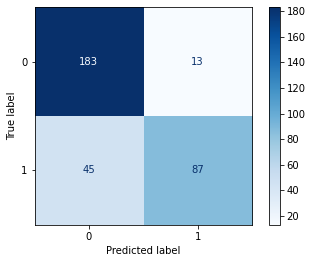

In [47]:
model13 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe13, params13, display_coeff=True)

#### Model 14: CountVectorizer with RandomForestClassifier

In [48]:
pipe14 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rt', RandomForestClassifier(n_estimators = 1000, n_jobs = -1))
])

params14 = {'cvec__max_features': [500,1000],
            'cvec__ngram_range':[(1,2)],
            'rt__max_depth': [15,25,35],
            'rt__min_samples_leaf': [1,2,3]
}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Grid Search Score: 0.7798249248938154
Best Params: {'cvec__max_features': 500, 'cvec__ngram_range': (1, 2), 'rt__max_depth': 35, 'rt__min_samples_leaf': 1}
Best Model Train Score: 0.8960244648318043
Best Model Test Score: 0.8048780487804879


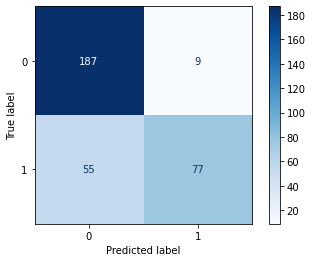

In [49]:
model14 = pipeline_gscv(X_train_features, y_train, X_test_features, y_test, pipe14, params14, display_coeff=False)

### d. Chosen Model: CountVectorizer with MultinomialNB

CountVectorizer with MultinominalNB gave us the best accuracy without overfitting out of the 3 models. Here we shall refit the model with all the data and explore the model more.

##### Metrics

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, model12.predict(X_test_features)).ravel()

In [51]:
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

,0,1
0,Accurary,0.844512
1,Misclassification,0.155488
2,Sensitivity,0.765152
3,Specificity,0.897959
4,Precision,0.834711


##### False Positives and False Negatives of the test set

In [52]:
X_test_check_model12 = pd.DataFrame(X_test_features)
X_test_check_model12['y_predict'] = model12.predict(X_test_features)
X_test_check_model12['y'] = y_test.reset_index(drop = True)
X_test_check_model12 = pd.concat([X_test_check_model12, 
                                 pd.DataFrame(model12.predict_proba(X_test_features), columns=('btc prob','eth prob'))], 
                                 axis = 1
                                )

##### False positives

In [53]:
pd.options.display.max_colwidth=1000
X_test_fp = X_test_check_model12[(X_test_check_model12['y_predict'] == 1) & (X_test_check_model12['y'] == 0)]

In [54]:
X_test_fp.head(10)

,0,y_predict,y,btc prob,eth prob
8,crack md5 hash blockchain curiou md5 hash blockchain crack super comput sort digit coin collect smelt kind electron furnac buddi say thi might work,1,0,0.277945,0.722055
12,layer 3 impervi ai interview websit impervi provid infrastructur secur transport host data privat cloud server ensur unfett access preserv oper integr leverag lightn network impervi open instant secur channel ensur shield access data host privat cloud servic impervi deplatform attempt meritless takedown request arbitrari servic interrupt,1,0,0.161343,0.838657
16,privat key hello everyon know thi stupid would like know gener 12 19 32 word passphras privat key quit new paper wallet think store money look way save privat key secur,1,0,0.054339,0.945661
34,babylon bee guid crypto,1,0,0.471927,0.528073
47,distribut hello doe anybodi idea distribut exampl x amount fall percentil owner accur data thank,1,0,0.264367,0.735633
48,logic valu,1,0,0.451745,0.548255
55,thi deadcat bounc befor inevit graph look aw lot like,1,0,0.387901,0.612099
85,sourc code want understand sourc code programm understand fairli technic stuff ani walkthrough video ani articl explain sourc code work thank,1,0,0.002559,0.997441
90,build v0 21 1 fedora 34 follow build unix md build core v0 21 1 sourc fedora 34 need libdb4 devel libdb4 cxx devel per build unix md depend doe exist dnf fedora 34 safest way get,1,0,0.045459,0.954541
98,improv propos bip bip process,1,0,0.031317,0.968683


In [55]:
X_test_fp_cvec = X_test_fp[0]
cvec_fp = CountVectorizer()
cvec_fp_ = cvec_fp.fit_transform(X_test_fp_cvec)
pd.DataFrame(cvec_fp_.toarray().sum(axis=0).tolist(), cvec_fp.get_feature_names()).sort_values(0, ascending = False).head()

,0
apr,16
api,14
interest,13
thi,11
privat,9


##### False Negatives

In [56]:
X_test_fn = X_test_check_model12[(X_test_check_model12['y_predict'] == 0) & (X_test_check_model12['y'] == 1)].head(20)

In [57]:
X_test_fn.head(10)

,0,y_predict,y,btc prob,eth prob
3,popular phillip auction hous accept crypto banksi artwork,0,1,0.946297,0.053703
4,countri adopt next legal recogn store valu currenc vote countri think adopt futur smart chain world view poll,0,1,0.999867,0.000133
9,po bring regulatori hammer take deposit pay interest dividend seem like whole new regulatori world much traffic node validat need regul like bank insur deposit,0,1,0.998470,0.001530
26,next gener investor one four student crypto,0,1,0.896981,0.103019
54,simpl explan whi need blockchain technolog know hear hot stock pick think gotta get thi one hope skip jump onto favorit trade ap find fund littl low need deposit coin miss next great amc gme hit deposit boom fund avail trade 5 6 busi day well slap nut steal money right wallet think thi whi need blockchain elimin middl man get immedi access right mean whi miss lose money everyon els ypu wait fund money want,0,1,0.999850,0.000150
56,futur money digit currenc revolut may sweep away 5 000 year monetari histori,0,1,0.999974,0.000026
61,wallet ledger amazon hi coinbas much commit buy small amount week next year want buy wallet ledger know hope guy give recommend ledger buy amazon safe easi transfer coinbas need everyth secur onc ledger ani help much appreci,0,1,0.950702,0.049298
64,newsweek dismiss digit art max raskin,0,1,0.889801,0.110199
86,someon tri tell scam pretti confid promis hold howev friend show thi podcast episod appar make bold claim scam ani truth person say thi video bullshit,0,1,0.962577,0.037423
114,recruit crypto believ get help tri fight misinform thi space sinc 2013 thi week request invest compani facebook privat user pleas take minut report thi shit hurt space reput tri achiev best could wa report burn hour time piss titl themselv crypto expert know fuck much appreci advanc lt 3 legitim crypto peopl,0,1,0.998727,0.001273


In [58]:
X_test_fn_cvec = X_test_fn[0]
cvec_fn = CountVectorizer()
cvec_fn_ = cvec_fn.fit_transform(X_test_fn_cvec)
pd.DataFrame(cvec_fn_.toarray().sum(axis=0).tolist(), cvec_fn.get_feature_names()).sort_values(0, ascending = False).head()

,0
crypto,9
thi,9
need,5
get,4
ani,4


Looking at the posts which are misclassified, these are posts which seem to be talking about crypto more in general rather than Bitcoin or Ethereum. Also there were a number of spam posts. Most of these posts, we wouldn't be able to differentiate them into Bitcoin or Ethereum posts ourselves and we accept them as outliers.

### 6. Final Model 

In [59]:
X = data['text']
y = data['subreddit']
X_features = preparetext(X)

#### Baseline for the whole dataset

In [60]:
y.value_counts(normalize=True)

0    0.598167
1    0.401833
Name: subreddit, dtype: float64

#### Refitting the whole dataset

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Grid Search Score: 0.8067269164399988
Best Params: {'cvec__max_df': 0.1, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.5}
Best Model Score: 0.8724216959511077


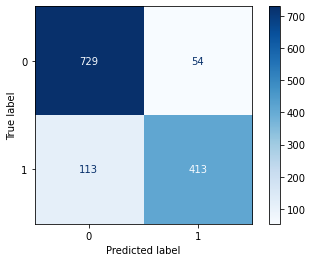

In [61]:
pipe16 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params16 = {'cvec__max_df': [0.1,0.2,0.3],
            'cvec__max_features': [500,800,1000],
            'cvec__min_df': [1,2,3],
            'cvec__ngram_range':[(1, 1),(1,2)],
            'nb__alpha': [0.4,0.5]
           }

gs16 = GridSearchCV(pipe16,
                    param_grid = params16,
                    cv = 5,
                    verbose = 1)

gs16.fit(X_features, y)

print(f'Best Grid Search Score: {gs16.best_score_}')
print(f'Best Params: {gs16.best_params_}')
model16 = gs16.best_estimator_
print(f'Best Model Score: {model16.score(X_features,y)}')
plot_confusion_matrix(model16, X_features, y, cmap='Blues', values_format='d');

In [62]:
tn, fp, fn, tp = confusion_matrix(y, model16.predict(X_features)).ravel()

In [63]:
pd.DataFrame([
    ('Accurary', (tn+tp)/(tn+tp+fp+fn)),
    ('Misclassification', (fp+fn)/(tn+tp+fp+fn)),
    ('Sensitivity', tp/(tp+fn)),
    ('Specificity', tn/(tn+fp)),
    ('Precision', tp/(tp+fp))
])

,0,1
0,Accurary,0.872422
1,Misclassification,0.127578
2,Sensitivity,0.785171
3,Specificity,0.931034
4,Precision,0.884368


In [64]:
coefficients = pd.DataFrame(model16[-1].feature_log_prob_.T, index = model16[0].get_feature_names(), columns = ['btc','eth'])
coefficients['prob_diff'] = np.exp(coefficients['eth']) - np.exp(coefficients['btc'])
display(coefficients.sort_values('prob_diff',ascending = True).head(10))
display(coefficients.sort_values('prob_diff', ascending = False).head(10))

,btc,eth,prob_diff
el,-4.992807,-8.098469,-0.006483
el salvador,-5.017198,-8.098469,-0.006319
salvador,-5.017198,-8.098469,-0.006319
currenc,-5.187250,-7.099940,-0.004762
mine,-5.033796,-6.283179,-0.004647
buy,-5.009001,-6.194232,-0.004636
bank,-5.187250,-6.908885,-0.004588
year,-5.042199,-5.933505,-0.003810
energi,-5.547415,-8.945767,-0.003767
price,-5.158401,-6.194232,-0.003710


,btc,eth,prob_diff
ga,-7.802209,-4.891088,0.007104
stake,-7.565821,-4.914481,0.006822
token,-8.900822,-5.040433,0.006335
contract,-7.291384,-5.000954,0.006050
eip,-10.510260,-5.154030,0.005749
blockchain,-5.977660,-4.824023,0.005500
smart,-7.565821,-5.316991,0.004390
defi,-7.374765,-5.299447,0.004367
smart contract,-7.945310,-5.390419,0.004206
state,-7.013752,-5.282205,0.004182


Our final model have an accuracy of 0.87%. 
The most important features are: 

| Class    | Features    | Description                                                                                                                                                 |
|----------|-------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Bitcoin  | el salvador | El Salvador became the first country in the world to adopt bitcoin as legal tender                                                                          |
|          | currenc     | Bitcoin is the most used decentralized digital currency,                                                                                                    |
|          | mine        | Bitcoin uses POW where new currencies are 'mine'. Ethereum uses POS where new currencies are 'staked'                                                       |
|          | buy         | Many posts advocating the merits of buying Bitcoins
                                                                            |
|          | bank        | Central Banks advising that Bitcoins being highly speculative
                                                                                         |
|          |             |                                                                                                                                                             |
| Ethereum | ga          | Gas is the fee for conducting a Ethereum transcation                                                                                                        |
|          | stake       | Bitcoin uses POW where new currencies are 'mine'. Ethereum uses POS where new currencies are 'staked'                                                       |
|          | token       | On the Ethereum network, other than Ethereum currencies which are identified as coin, there are other cryptocurrencies or NFT which are identified as tokens |
|          | contract    | Part of Ethereum is it allows smart contracts to be stored on Ethereum network                                                                              |
|          | eip         | EIP is Ethereum Improvement Proposals                                                                                                                       |

## 6. Conclusion and Recommendations


|             | CountVectorizer with MultinomialNB | Tfidf Vectorizer with Logistic Regression | CountVectorizer with RandomForestClassifier |
|-------------|------------------------------------|-------------------------------------------|---------------------------------------------|
| Params      | 'cvec__max_df': 0.2                |  'tfidf__max_df': 0.2                     | 'cvec__max_features': 1000                  |
|             | cvec__max_features': 1000          | 'tfidf__max_features': 1000               |  'cvec__ngram_range': (1, 2)                |
|             | cvec__min_df': 2                   | tfidf__min_df': 3                         | rt__max_depth': 35                          |
|             | cvec__ngram_range': (1, 1)         | 'tfidf__ngram_range': (1, 2)              | 'rt__min_samples_leaf': 1                   |
|             | nb__alpha': 0.4                    | ''lr__C': 1,                              |                                             |
| Train Score | 0.881                              | 0.901                                     | 0.897                                       |
| Test Score  | 0.845                              | 0.823                                     | 0.795                                       |

Recap: We tried various models. Logistic Regression produce pretty consisent accuracy. Multinominal Naive Bayes worked the best. K Nearest Neighbours Classifier doesn't seem to perform well. Random Forest Classifier is around the same accuracy as Logistic Regression but still not better than Multinominal Naive Bayes. HashingVectorizer doesn't give much benefit and have more disadvantages for this dataset. We tried to fine tune 3 model: Model 2: MultinominalNB with CountVectorizer, Model 4: LogisticRegression with TfidfVectorizer and Model 10: Random Forest with CountVectorizer.

One of the challenges we face during the course of this project is that our models overfit most of the times and we have to find ways and trying different hyperparameters to prevent the model from overfitting without sacrificing accuracy. For our final 3 models, we discover that Multinominal respond best to our efforts to prevent overfitting. It was able to increase accuracy of the test score while minimizing the difference between our train and test score to around 4% and improving our cross val score. We find it hard to prevent overfitting on the Random Forest model as once we limit the max depth or increase the minimum sample leaf, our test score dropped drastically from 0.82 to 0.795. For the Logistic Regression model, we managed to reduce to 8% difference between the train and test score and still achieve 0.82 test score.

We choose Multinominal Naive Bayes with CountVectorizer as our final model as it is the model that still maintain its highest accuracy score and also is not overfitted. Also it is the fastest to tune and compute over GridSearchCV. Our best params are the following: 'cvec__max_df': 0.1, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.5

We are satisfied with our results that it 84.5% accurate which beat the baseline accuracy by 24.8% and is better than the other models by 2-3%. Also the train score and test score are not significantly different thus not overfitting. This meet our goal of being able to differentiate and classify posts into Bitcoins posts and Ethereum posts reasonably well. We also resonate with the most important features in this model and they are similar with the most important features in other models as well. A look at the posts which are misclassified show these posts mainly outliers which are either spam or didn't belong to either classes which we cannot differentiate with our human brains either. In short, we believe our model to be adequte to solve the problem statement.

Going forward, since most of our models show overfitting due to the larger number of features to our dataset, we can improve our accuracy by gathering more data given time and refitting it to our model and relaxing some of the hyperparameters used to control the overfitting.



## 7. References and Data Sources

1. https://www.reddit.com/